## Notation


The EWMA for a financial time series $S_t, t \in \set{0,\dots,T}$ is given by:


$$
\begin{cases}
EWMA_t = S_0 &,t = 0 \\
EWMA_t = \alpha \cdot S_t + (1- \alpha) \cdot EWMA_{t-1} &,t \in \set{1,\dots, T}.
\end{cases}
$$


In [210]:
from pylab import mpl, plt

In [211]:
style = 'seaborn-v0_8'
plt.style.use(style)
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

### Python


In [212]:
import pandas as pd

In [213]:
sym = 'SPY'
data = pd.DataFrame(pd.read_csv("../../Data/tr_eikon_eod_data.csv", 
                                index_col=0, 
                                parse_dates=True)[sym]).dropna()
data.head(2)

,SPY
Date,
2010-01-04,113.33
2010-01-05,113.63


In [214]:
data['EWMA'] = data[sym]

In [215]:
def ewma_py():
    alpha = 0.25
    for t in zip(data.index,data.index[1:]):
        data.loc[t[1], 'EWMA'] = (alpha * data.loc[t[1], sym] +
                                (1 - alpha) * data.loc[t[0], 'EWMA'])
    
%time ewma_py()

CPU times: total: 46.9 ms
Wall time: 128 ms


In [216]:
data.head(5)

,SPY,EWMA
Date,,
2010-01-04,113.33,113.330000
2010-01-05,113.63,113.405000
2010-01-06,113.71,113.481250
2010-01-07,114.19,113.658438
2010-01-08,114.57,113.886328


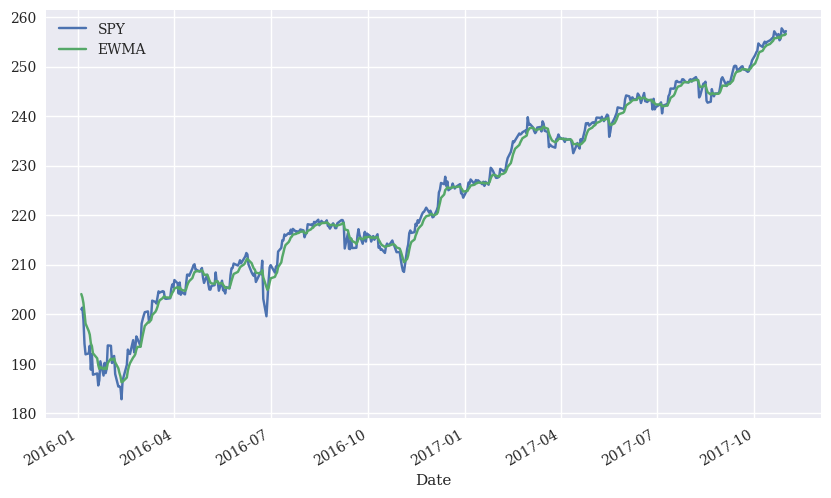

In [217]:
data[data.index > '2016-1-1'].plot(figsize=(10, 6));

### Numpy


In [218]:
import numpy as np

In [219]:
def ewma_np(x, alpha):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1-alpha) * y[i-1]
    return y

In [220]:
%time data['EWMA_NP'] = ewma_np(data[sym], alpha=0.25)

CPU times: total: 0 ns
Wall time: 1.5 ms


In [221]:
data.head(2)

,SPY,EWMA,EWMA_NP
Date,,,
2010-01-04,113.33,113.330,113.330
2010-01-05,113.63,113.405,113.405


## Numba


In [222]:
import numba as nb

In [223]:
ewma_nb = nb.jit(ewma_np)

In [224]:
%time data['EWMA_NB'] = ewma_np(data[sym], alpha=0.25)

CPU times: total: 0 ns
Wall time: 999 µs


### Cython


In [225]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [226]:
%%cython

import numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def ewma_cy(double[:] x, float alpha):
    cdef int i
    cdef double[:] y = np.empty_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i - 1]  
    return np.asarray(y)


In [227]:
%time data['EWMA_CY'] = ewma_cy(data['SPY'].values, alpha)

CPU times: total: 0 ns
Wall time: 501 µs


In [229]:
data.head()

,SPY,EWMA,EWMA_NP,EWMA_NB,EWMA_CY
Date,,,,,
2010-01-04,113.33,113.330000,113.330000,113.330000,113.330000
2010-01-05,113.63,113.405000,113.405000,113.405000,113.405000
2010-01-06,113.71,113.481250,113.481250,113.481250,113.481250
2010-01-07,114.19,113.658438,113.658438,113.658438,113.658438
2010-01-08,114.57,113.886328,113.886328,113.886328,113.886328
